In [2]:
import numpy as np
import qiskit
from qiskit.quantum_info import state_fidelity

from numpy import linalg as LA
import qib
import matplotlib.pyplot as plt
import scipy
import h5py

import sys
sys.path.append("../../src/brickwall_sparse")
from utils_sparse import construct_ising_local_term, reduce_list, X, I2, get_perms
from ansatz_sparse import ansatz_sparse
import rqcopt as oc
from scipy.sparse.linalg import expm_multiply
from qiskit.quantum_info import random_statevector

Lx, Ly = (4, 4)
L = Lx*Ly
t = .1
layers=6
latt = qib.lattice.IntegerLattice((Lx, Ly), pbc=True)
field = qib.field.Field(qib.field.ParticleType.QUBIT, latt)
J, h, g = (1, 0, 3)
hamil = qib.IsingHamiltonian(field, J, h, g).as_matrix()
eigenvalues, eigenvectors = scipy.sparse.linalg.eigsh(hamil, k=20)
idx = eigenvalues.argsort()
eigenvalues_sort = eigenvalues[idx]
eigenvectors_sort = eigenvectors[:,idx]
ground_state = eigenvectors_sort[:, 0]

X = np.array([[0, 1], [1, 0]])
Z = np.array([[1, 0], [0, -1]])
Y = np.array([[0, -1j], [1j, 0]])
I2 = np.array([[1, 0], [0, 1]])

perms_v, perms_h = get_perms(Lx, Ly)
"""perms_v, perms_h = (
    [[0 , 1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35],
    [1, 2, 3, 4, 5, 0, 7, 8, 9, 10, 11, 6, 13, 14, 15, 16, 17, 12, 19, 20, 21, 22, 23, 18, 25, 26, 27, 28, 29, 24, 31, 32, 33, 34, 35, 30]],
    [[0, 6, 12, 18, 24, 30, 1, 7, 13, 19, 25, 31, 2, 8, 14, 20, 26, 32, 3, 9, 15, 21, 27, 33, 4, 10, 16, 22, 28, 34, 5, 11, 17, 23, 29, 35], 
    [6, 12, 18, 24, 30, 0, 7, 13, 19, 25, 31, 1, 8, 14, 20, 26, 32, 2, 9, 15, 21, 27, 33, 3, 10, 16, 22, 28, 34, 4, 11, 17, 23, 29, 35, 5]]
)"""


"""control_layers = [0, 4, 5, 9, 10, 14] # 6 control layers
perms_v, perms_h = get_perms(Lx, Ly)
perms_extended = [[perms_v[0]]] + [perms_v]*3 + [[perms_v[0]], [perms_h[0]]] +\
                    [perms_h]*3 + [[perms_h[0]], [perms_v[0]]] + [perms_v]*3 + [[perms_v[0]]]
perms_ext_reduced = [perms_v]*3  + [perms_h]*3 + [perms_v]*3
"""
print("GSE1", eigenvalues_sort[0])
print("GSE2", eigenvalues_sort[2])


GSE1 -51.448129133206066
GSE2 -47.4734874602213


In [631]:
gs = np.linspace(1, 5, 20)
Es = []
for g in gs:
    latt = qib.lattice.IntegerLattice((Lx, Ly), pbc=True)
    field = qib.field.Field(qib.field.ParticleType.QUBIT, latt)
    J, h = (1, 0)
    hamil = qib.IsingHamiltonian(field, J, h, g).as_matrix()
    eigenvalues, eigenvectors = scipy.sparse.linalg.eigsh(hamil, k=20)
    idx = eigenvalues.argsort()
    eigenvalues_sort = eigenvalues[idx]
    eigenvectors_sort = eigenvectors[:,idx]
    Es.append(eigenvalues_sort[0])

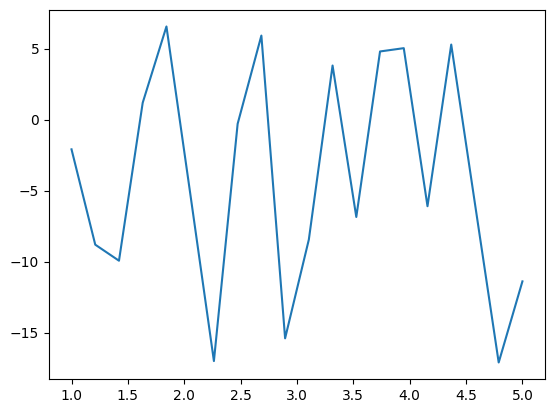

In [647]:
#plt.plot(gs, Es)
plt.plot(gs, np.gradient(np.gradient([E+ (0.5 if np.random.rand()<0.5 else -0.5) for E in Es], gs), gs))

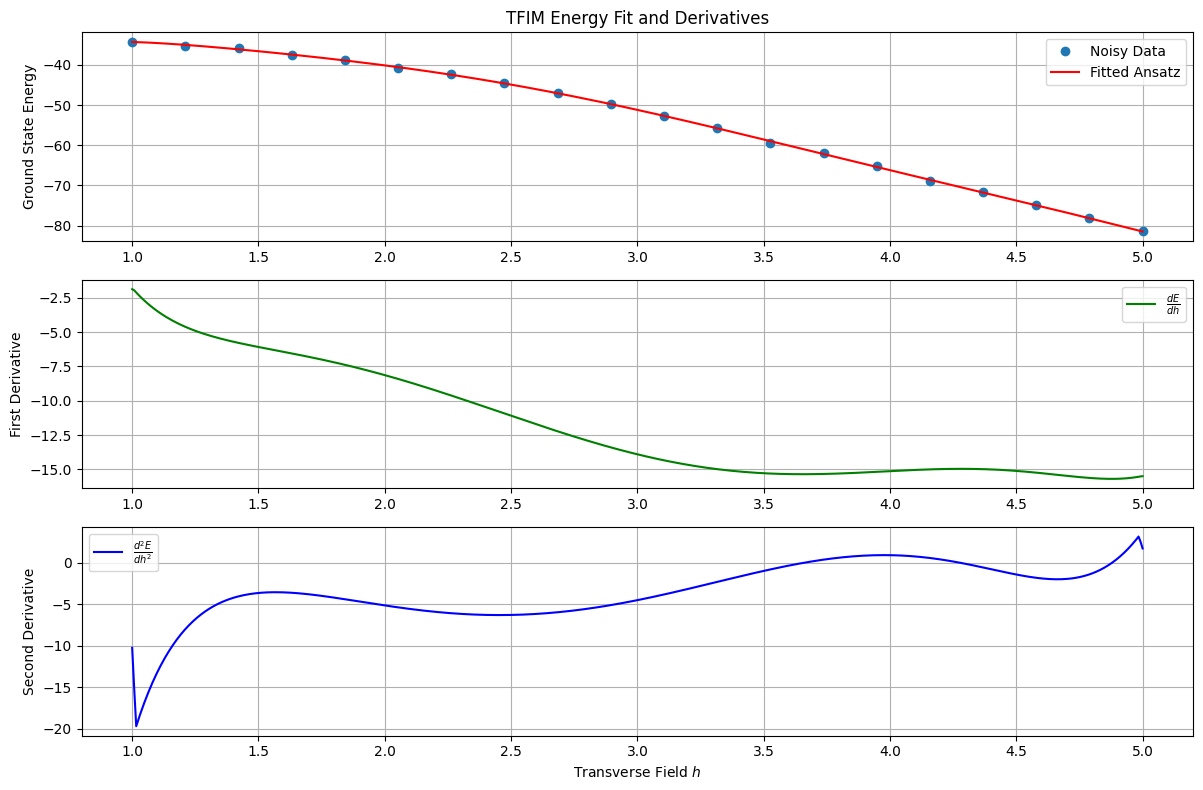

In [695]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.ndimage import gaussian_filter1d

# === 1. Define physically-motivated Ansatz ===
def tfim_energy_ansatz(h, a0, a1, a2, a3, a4, b, c, d, hc):
    return a0 + a1*h + a2*h**2 + a3*h**3 + a4*h**4 + b/h + c * np.tanh(d * (h - hc))

# === 2. Example: Fake noisy data (replace with your own) ===
E_noisy = [E+ (0.25 if np.random.rand()<0.5 else -0.25) for E in Es]

# === 3. Fit the Ansatz to the noisy data ===
p0 = [-4, 0.1, 0.01, 1.0, 0, 0, -1.0, 1.0, 3.0]  # initial guess
popt, _ = curve_fit(tfim_energy_ansatz, gs, E_noisy, p0=p0)

# === 4. Evaluate fit and derivatives on fine grid ===
h_fine = np.linspace(1, 5, 500)
E_fit = tfim_energy_ansatz(h_fine, *popt)
dE = np.gradient(E_fit, h_fine)
d2E = np.gradient(dE, h_fine)

# === 5. Plotting ===
plt.figure(figsize=(12, 8))

# Energy
plt.subplot(3, 1, 1)
plt.plot(gs, E_noisy, 'o', label='Noisy Data')
plt.plot(h_fine, E_fit, 'r-', label='Fitted Ansatz')
plt.ylabel('Ground State Energy')
plt.title('TFIM Energy Fit and Derivatives')
plt.legend()
plt.grid(True)

# First Derivative
plt.subplot(3, 1, 2)
plt.plot(h_fine, dE, 'g-', label=r"$\frac{dE}{dh}$")
plt.ylabel('First Derivative')
plt.legend()
plt.grid(True)

# Second Derivative
plt.subplot(3, 1, 3)
plt.plot(h_fine, d2E, 'b-', label=r"$\frac{d^2E}{dh^2}$")
plt.xlabel('Transverse Field $h$')
plt.ylabel('Second Derivative')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

/tmp/ipykernel_34540/15487825.py:13: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(energy_model, gs, noisy_E, p0=[-1, 0, 0, 0, 0, -1, 1, 3])


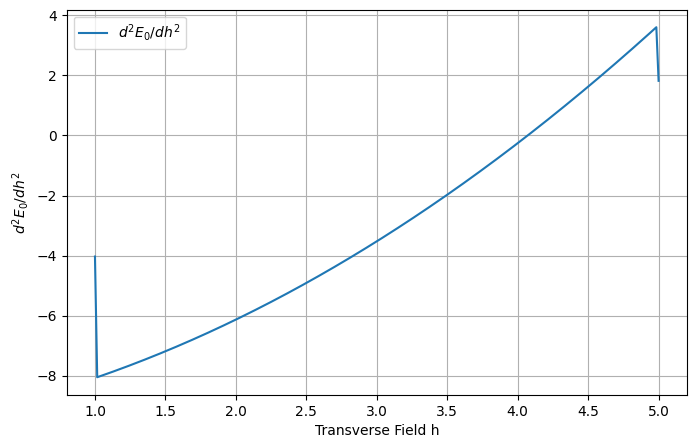

In [674]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# Sample model function
def energy_model(h, a0, a1, a2, a3, a4, b, c, hc):
    poly = a0 + a1*h + a2*h**2 + a3*h**3 + a4*h**4 
    sigmoid = b / (1 + np.exp(-c*(h - hc)))
    return poly + sigmoid

# Fit the noisy data
noisy_E = [E+ (0.5 if np.random.rand()<0.5 else -0.5) for E in Es]
popt, _ = curve_fit(energy_model, gs, noisy_E, p0=[-1, 0, 0, 0, 0, -1, 1, 3])s
# Fine grid for second derivative
h_fine = np.linspace(1, 5, 500)
E_fit = energy_model(h_fine, *popt)

# Second derivative (using finite diff of smooth curve)
d2E = np.gradient(np.gradient(E_fit, h_fine), h_fine)

# Plot
plt.figure(figsize=(8,5))
plt.plot(h_fine, d2E, label=r"$d^2E_0/dh^2$")
#plt.plot(h_fine, E_fit, label=r"$E_0$")
#plt.scatter(gs, noisy_E)
#plt.axvline(popt[-1], color='r', linestyle='--', label=f"Estimated $h_c \\approx {popt[-1]:.3f}$")
plt.xlabel("Transverse Field h")
plt.ylabel(r"$d^2E_0/dh^2$")
plt.legend()
plt.grid(True)
plt.show()

In [403]:
#gs = np.linspace(1, 4, 100)
Es = []
for g in gs:
    Lx, Ly = (4, 4)
    L = Lx*Ly
    t = .125
    latt = qib.lattice.IntegerLattice((Lx, Ly), pbc=True)
    field = qib.field.Field(qib.field.ParticleType.QUBIT, latt)
    J, h = (1, 0)
    hamil = qib.IsingHamiltonian(field, J, h, g).as_matrix()
    eigenvalues, eigenvectors = scipy.sparse.linalg.eigsh(hamil, k=20)
    idx = eigenvalues.argsort()
    eigenvalues_sort = eigenvalues[idx]
    eigenvectors_sort = eigenvectors[:,idx]
    #print('g=', g, ' ', eigenvalues_sort[0])
    Es.append(eigenvalues_sort[0])

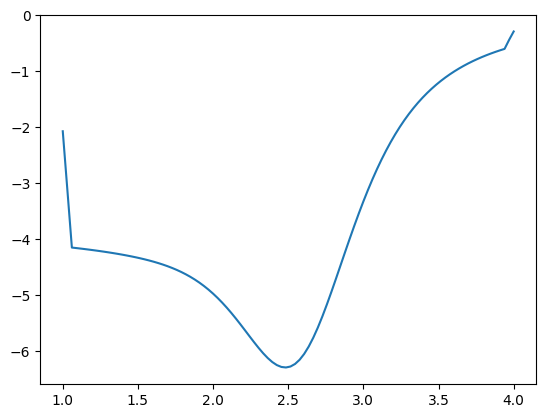

In [408]:
#plt.plot(gs, Es)
plt.plot(gs, np.gradient(np.gradient(Es, gs), gs))

In [44]:
"""
    Compressed-Controlled Time Evolution Operator that we optimized previously.
"""
import h5py
import sys
sys.path.append("../../src/brickwall_sparse")
from ansatz_sparse import ansatz_sparse, construct_ccU

#perms_qc = [[0, 1], [0, 2], [1, 2], [0, 2], [0, 1], [1, 2], [0, 2], [0, 1], [1, 2]]
perms_qc = [[0, 1], [0, 2]]
Xlists_opts = {}
Vlists = {}
qc_cUs = {}
layers = 6
ts = [.125, 0.18, 0.19, 0.2, 0.21, 0.22, 0.24, 0.25]
for t in [0.125, 0.2]:
    Vlist = []

    if layers == 6:
        with h5py.File(f"./results/tfim2d_ccU_SPARSE_10{g}_Lx4Ly4_t{t}_layers6_niter8_rS1_2hloc.hdf5", "r") as f:
            Vlist =  f["Vlist"][:]
        perms_extended = [[perms_v[0]]] + [perms_v]*1 + [[perms_v[0]], [perms_h[0]]] +\
                            [perms_h]*1 + [[perms_h[0]]]
        perms_ext_reduced = [perms_v]*1  + [perms_h]*1
        control_layers = [0, 2, 3, 5]           # 4 control layers
    elif layers ==10:
        with h5py.File(f"./results/tfim2d_ccU_SPARSE_10{g}_Lx4Ly4_t{t}_layers10_niter8_rS1_2hloc.hdf5", "r") as f:
            Vlist =  f["Vlist"][:]
        perms_extended = [[perms_v[0]]] + [perms_v]*3 + [[perms_v[0]], [perms_h[0]]] +\
                            [perms_h]*3 + [[perms_h[0]]]
        perms_ext_reduced = [perms_v]*3  + [perms_h]*3
        control_layers = [0, 4, 5, 9]           # 4 control layers
    
    Xlists_opt = {}
    for i in control_layers:
        with h5py.File(f"./results/tfim2d_ccU_SPARSE_{J}{h}{g}_Lx4Ly4_t{t}_layers{len(Vlist)}_niter15_rS1_DECOMPOSE_n{len(perms_qc)}_layer{i}.hdf5", "r") as file:
            Xlists_opt[i] = file[f"Xlist_{i}"][:]

    
    Xlists_opts[t] = Xlists_opt
    Vlists[t] = Vlist
    qc_cUs[t] = construct_ccU(L, Vlist, Xlists_opt, perms_extended, perms_qc, control_layers)


In [8]:
from qiskit.quantum_info import random_statevector
from scipy.sparse.linalg import expm_multiply
from qiskit import Aer, execute, transpile
from qiskit.circuit.library import CYGate, CZGate, IGate, CXGate
from qiskit.converters import circuit_to_dag
from qiskit.providers.aer.noise import NoiseModel, errors
from qiskit import Aer, execute, transpile
from scipy import sparse as sp


for t_ in [.125]:
    qc = qc_cUs[t_]
    state = random_statevector(2**L).data
    qc_ext1 = qiskit.QuantumCircuit(L+1)
    qc_ext1.initialize(state, [i for i in range(L)])
    for i in range(int(t_/t_)):
        qc_ext1.append(qc.to_gate(), [i for i in range(L+1)])
    backend = Aer.get_backend("statevector_simulator")
    sv1 = execute(transpile(qc_ext1), backend).result().get_statevector().data
    
    qc_ext2 = qiskit.QuantumCircuit(L+1)
    qc_ext2.initialize(state, [i for i in range(L)])
    qc_ext2.x(L)
    for i in range(int(t_/t_)):
        qc_ext2.append(qc.to_gate(), [i for i in range(L+1)])
    backend = Aer.get_backend("statevector_simulator")
    sv2 = execute(transpile(qc_ext2), backend).result().get_statevector().data

    ket_0 = np.array([1, 0])
    ket_1 = np.array([0, 1])
    exact_v1 = np.kron(ket_0, expm_multiply(1j * t_ * hamil, state))
    exact_v2 = np.kron(ket_1, expm_multiply(-1j * t_ * hamil, state))
    #err = (np.linalg.norm(sv1-exact_v1, ord=2) + np.linalg.norm(sv2-exact_v2, ord=2))/2
    err = (1-state_fidelity(sv1, exact_v1) + 1-state_fidelity(sv2, exact_v2))/2

    noise_model = NoiseModel()
    dag = circuit_to_dag(transpile(qc_ext1, basis_gates=noise_model.basis_gates+['unitary', 'initialize', 'cx']))
    count_ops = dag.count_ops()
    
    print(f"t={t_}, Gate Count: ", count_ops['unitary'], " Infid. error: ", err)

t=0.125, Gate Count:  96  Infid. error:  0.01163378759352629


In [9]:
"""

    Exact Initialization + Iterative QPE
    Let's assume we can efficiently encode a DMRG ground state.

"""
import sys
sys.path.append("../../src/qpe")
from qpe import estimate_phases

def norm_mod2pi(theta):
    return np.pi - np.abs((theta%(2*np.pi)) - np.pi) 

def run_QPE(qc_prepared_state, qc_cU, basis_time, init_guess, Ns, final_digit, depolarizing_error, custom_phase=None, 
            hide_print=False, init_digit=-1, custom_T=None):
    theta_prev = -init_guess
    est_prev = init_guess

    x1_error = errors.depolarizing_error(depolarizing_error*0.01, 1)
    x2_error = errors.depolarizing_error(depolarizing_error, 2)
    noise_model = NoiseModel()
    noise_model.add_all_qubit_quantum_error(x1_error, ['u1', 'u2', 'u3'])
    noise_model.add_all_qubit_quantum_error(x2_error, ['cu3', 'cx', 'str', 'cy', 'cz', 'unitary'])
    
    Es = []
    ests_ = []
    thetas_ = []
    cxss_A = []
    mid_cbits = 0
    mid_errs_A = []
    for j in list(range(init_digit, final_digit+1, 1)):
        if custom_T is None:
            T = 2**j
        else:
            T = custom_T*2
        
        if custom_phase is None:
            theta_prev_ = theta_prev
            counts_real, counts_imag, cxs = estimate_phases(
                                                    L, qc_C, eigenvalues_sort, T/2, basis_time,
                                                    Ns, depolarizing_error, qc_cU, noise_model=noise_model,
                                                    return_counts=True,
                                                    get_cx=True, qasm=False
                                               )[0]
            #cxss_A.append(cxs['unitary'])
            #print('CXs: ', cxss_A[-1])
            print(cxs)
        
            phase_est_real = ((counts_real['0'] if '0' in counts_real else 0) - (counts_real['1'] if '1' in counts_real else 0)) /\
                        ((counts_real['0'] if '0' in counts_real else 0) + (counts_real['1'] if '1' in counts_real else 0))     
            phase_est_imag = ((counts_imag['0'] if '0' in counts_imag else 0) - (counts_imag['1'] if '1' in counts_imag else 0)) /\
                        ((counts_imag['0'] if '0' in counts_imag else 0) + (counts_imag['1'] if '1' in counts_imag else 0))
            phase = phase_est_real + 1j*phase_est_imag
        else:
            T, phase = custom_phase

        if not hide_print:
            print("Exact Phase: ", np.exp(-1j * T * eigenvalues_sort[0]))
            print("Estimated Phase: ", phase)
            print("Estimated Phase Amplitude: ", np.linalg.norm(phase))
                
        if phase.real != 0:
            angle = np.arctan(phase.imag/phase.real) if phase.real>0 else (np.pi + np.arctan(phase.imag/phase.real) if phase.imag>0 else \
                                                                               np.arctan(phase.imag/phase.real) - np.pi)
        else:
            angle = np.pi/2 if phase.imag > 0 else -np.pi/2

    
        if T>1:
            thetas = [(angle + k*2*np.pi)/T for k in range(T+1)]
            norms = np.array([norm_mod2pi(theta - theta_prev) for theta in thetas])
            id_ = np.argmin(norms)
                    
            ests = [-thetas[id_] - coe*np.pi for coe in range(2, 40, 2)]
            est = ests[0]
            for est_ in ests[1:]:
                est = est_ if np.abs(est_-est_prev) < np.abs(est-est_prev) else est
            ests_.append(est)
            thetas_.append(thetas[id_])
            theta_prev = thetas_[-1]
        else:
            thetas = [(angle + k*np.pi)/T for k in range(0, 40, 2)]
            ests = [-theta for theta in thetas]
            est = ests[0]
            for est_ in ests[1:]:
                est = est_ if np.abs(est_-est_prev) < np.abs(est-est_prev) else est
            ests_.append(est)
            thetas_.append(-est)
            theta_prev = thetas_[-1]
    
        est_prev = ests_[-1]
        if not hide_print:
            print("Final Estimation Result, Abs Error: ", np.abs(est_prev-eigenvalues_sort[0]))    
            print("Final Estimation Result, Relative Error: ", np.abs(est_prev-eigenvalues_sort[0])/np.abs(eigenvalues_sort[0]), '\n')    
        mid_errs_A.append(np.abs(est_prev-eigenvalues_sort[0]))
        Es.append(est_prev)
    return Es

In [18]:
"""
    Adiabatic Evolution Implementation.
"""
from qiskit import Aer, transpile, execute

def trotter(Lx, Ly, tau, L, J_i, h_i, g_i, J_f, h_f, g_f, lamb, perms_v, perms_h):
    L = Lx * Ly
    assert lamb <= 1 and lamb >= 0
    J = lamb*J_f + (1-lamb)*J_i
    g = lamb*g_f + (1-lamb)*g_i
    h = lamb*h_f + (1-lamb)*h_i

    qc = qiskit.QuantumCircuit(L)
    hloc = construct_ising_local_term_(J, g, 2)
        
    perms = perms_v+perms_h
    perm_set = perms
    
    method_start = oc.SplittingMethod.suzuki(len(perm_set), 1)
    indices = method_start.indices
    coeffs = method_start.coeffs

    Vlist_start = []
    perms = []
    for i, c in zip(indices, coeffs):
        Vlist_start.append(scipy.linalg.expm(-1j*c*tau*hloc))
        perms.append(perm_set[i])
    Vlist_gates = []
    for V in Vlist_start:
        qc2 = qiskit.QuantumCircuit(2)
        qc2.unitary(V, [0, 1])
        Vlist_gates.append(qc2)
    
    for layer, qc_gate in enumerate(Vlist_gates):     
        for j in range(len(perms[layer])//2):
            qc.append(qc_gate.to_gate(), [L-(perms[layer][2*j]+1), L-(perms[layer][2*j+1]+1)])
    return qc


def construct_ising_local_term_(J, g, ndim, h=0):
    X = np.array([[0.,  1.], [1.,  0.]])
    Z = np.array([[1.,  0.], [0., -1.]])
    I = np.identity(2)
    return J*np.kron(Z, Z) + g*(0.5/ndim)*(np.kron(X, I) + np.kron(I, X)) + h*(0.5/ndim)*(np.kron(Z, I) + np.kron(I, Z))


def run_adiabatic(Lx, Ly, g, T, S, perms_v, perms_h, state=None, return_state=False, h_i=0, h_f=0):
    L = Lx*Ly
    tau = 1/S
    t_s = np.linspace(0, T, S*T)
    sch = lambda t, T: np.sin(np.pi*t/(2*T))**2
    
    qc = qiskit.QuantumCircuit(L)
    """if state is None:
        for y in range(Ly):
            for x in range(Lx):
                i = Ly * y + x  # qubit index in row-major order
                if (x + y) % 2 == 1:
                    qc.x(i)  # Flip qubit to |1⟩ (spin down)"""
    qc.x([i for i in range(L)])
    qc.h([i for i in range(L)])
    for s in range(S*T):
        qc.append(trotter(Lx, Ly, tau, L, 0, h_i, g, J, h_f, g, sch(t_s[s], T), perms_v, perms_h).to_gate(), [i for i in range(L)])
    
    backend = Aer.get_backend("statevector_simulator")
    qc_ = qiskit.QuantumCircuit(L)
    if state is not None:
        qc_.initialize(state)
    qc_.append(qc.to_gate(), [i for i in range(L)])
    final = execute(transpile(qc_), backend).result().get_statevector().data
    print("AQC: ", [np.linalg.norm(np.vdot(final, eigenvectors_sort[:, i]))**2 for i in range(10)])

    if return_state:
        return qc
    else:
        noise_model = NoiseModel()
        dag = circuit_to_dag(transpile(qc_, basis_gates=['unitary', 'u3', 'initialize']))
        count_ops = dag.count_ops()
        print(count_ops)
        
        #return [state_fidelity(final, eigenvectors_sort[:, i]) for i in range(10)], {"gates": count_ops}, final


In [40]:
Lx, Ly = (4, 4)
L = Lx*Ly
latt = qib.lattice.IntegerLattice((Lx, Ly), pbc=True)
field = qib.field.Field(qib.field.ParticleType.QUBIT, latt)

#H_i = qib.IsingHamiltonian(field, 0, 0, g).as_matrix()
#eigenvalues, eigenvectors = scipy.sparse.linalg.eigsh(H_i, k=10)
#eigenvalues, eigenvectors = np.linalg.eig(H_i.toarray())
#idx = eigenvalues.argsort()
#eigenvectors_sort = eigenvectors[:,idx]
#state = eigenvectors_sort[:, 0]

hamil = qib.IsingHamiltonian(field, J, h, g).as_matrix()
eigenvalues, eigenvectors = scipy.sparse.linalg.eigsh(hamil, k=10)
#eigenvalues, eigenvectors = np.linalg.eig(hamil.toarray())
idx = eigenvalues.argsort()
eigenvalues_sort = eigenvalues[idx]
eigenvectors_sort = eigenvectors[:,idx]
ground_state = eigenvectors_sort[:, 0]

qc_A = run_adiabatic(Lx, Ly, g, 0, 3, perms_v, perms_h, state=None, return_state=True)

AQC:  [0.5794138609135387, 1.5670528826546384e-28, 0.25866677728129045, 4.345379437023701e-33, 7.703719777548943e-34, 1.1353510465501511e-35, 2.104569162249e-34, 7.258621235072828e-11, 1.162489883220871e-32, 7.1082579779188234e-12]


In [41]:
qc = qiskit.QuantumCircuit(L+1)
qc.append(qc_A, [i for i in range(L)])
qc.append(qc_cUs[0.125], [i for i in range(L+1)])
dag = circuit_to_dag(transpile(qc, basis_gates=['unitary', 'u3', 'initialize']))
count_ops = dag.count_ops()
count_ops

{'u3': 18, 'unitary': 96}

In [42]:
"""
    T = 0: Longest path is 144 SU(4) unitaries -> 244
    T = 1: Longest path is 158 SU(4) unitaries -> 270
    T = 2: Longest path is 172 SU(4) unitaries -> 300
    
    T = 0: Total count is 216 SU(4) unitaries -> After 1-Opt compiling: 432
    T = 0: Total count is 468 SU(4) unitaries -> 792
    T = 0: Total count is 720 SU(4) unitaries -> 1224
"""

'\n    T = 0: Longest path is 144 SU(4) unitaries -> 244\n    T = 1: Longest path is 158 SU(4) unitaries -> 270\n    T = 2: Longest path is 172 SU(4) unitaries -> 300\n    \n    T = 0: Total count is 216 SU(4) unitaries -> After 1-Opt compiling: 432\n    T = 0: Total count is 468 SU(4) unitaries -> 792\n    T = 0: Total count is 720 SU(4) unitaries -> 1224\n'

In [47]:
from qiskit import QuantumCircuit

qc_C = qiskit.QuantumCircuit(L+1, 1)
# Flip qubits to create Néel order (checkerboard pattern)
#for y in range(Ly):
#    for x in range(Lx):
#        i = 4 * y + x  # qubit index in row-major order
#        if (x + y) % 2 == 1:
#            qc_C.x(i)  # Flip qubit to |1⟩ (spin down)
#qc_C.x([i for i in range(L)])
#qc_C.h([i for i in range(L)])
qc_C.append(qc_A.to_gate(), [i for i in range(L)])

T = 0.125
qc_cU = qc_cUs[T]
Es_ccU = run_QPE(qc_C, qc_cU, T, -45, 2000, -1, 0, custom_T=T)

t:  0.125
nsteps:  1
getting counts
{'rz': 36, 'sx': 18, 'unitary': 96, 'measure': 1}
Exact Phase:  (0.9566095593591457+0.2913728726952821j)
Estimated Phase:  (0.709-0.131j)
Estimated Phase Amplitude:  0.7210006934809424
Final Estimation Result, Abs Error:  1.9134736200263376
Final Estimation Result, Relative Error:  0.03719228769372908 



In [842]:
(48-152)/(48+152)+1j*(100+115-96-72)/(196+115+72)

(-0.52+0.1227154046997389j)

In [848]:
from qiskit.quantum_info import Statevector

#s = (ground_state * 0.7 + eigenvectors_sort[:, 1] * 0.3)
#s = s/np.linalg.norm(s)
qc_C = qiskit.QuantumCircuit(L+1, 1)
#qc_C.x([i for i in range(L)])
#qc_C.h([i for i in range(L)])
qc_C.append(qc_A.to_gate(), [i for i in range(L)])

# -56 is initial guess, corresponding to 8% error
# Initial error should be (ideally) around 8% for t=0.25 range.
Es_ccU = run_QPE(qc_C, qc_cU, t, -60, 2000, -1, 0, custom_phase=(0.1 * 2,
                                                                 #g=1
                                                                 #0.1232+0.2184j # t=0.2 -> From RZZ of 2500 shots, Counts: (1404-1096)/2000 + 1j * (1523-977)/2000
                                                                 #-0.117-0.49j # t=0.25
                                                                 #-0.33+0.14j # t=0.22
                                                                 #-0.3832-0.0008j #t=0.24
                                                                 #0.0888+0.3504j # t=0.21
                                                                 #0.4248-0.5328j #t=0.18
                                                                 #0.5096-0.3424j #t=0.19
                                                                 #0+1j # from t=0.125

                                                                 #g=2.5
                                                                 #-0.192+0.514j #, t=0.1
                                                                 #0.046-0.352j #, t=0.2

                                                                 #g=1, multi ancilla
                                                                 #0.377551+0.265306122j # t=0.2
                                                                 #-0.13402061855670103+0.16129032258064516j # t=0.22
                                                                 #0.14285714285714285+0.4897959183673469j # t=0.21
                                                                 #-0.17391304347826086+0.5234042553191489j # t=0.125
                                                                 #0.4063926940639269-0.4403292181069959j  # t=0.18
                                                                 #-0.3729254881757675+0.9278612936580907j # AFTER FIT, t=0.125

                                                                 # g=2.5, multi ancilla
                                                                 -0.52+0.1227j
                                                                ))


Exact Phase:  (-0.9187457220798094+0.3948497159173976j)
Estimated Phase:  (-0.52+0.1227j)
Estimated Phase Amplitude:  0.5342801605899288
Final Estimation Result, Abs Error:  0.8709064421815569
Final Estimation Result, Relative Error:  0.01931297570063823 



In [849]:
Es_ccU

[-45.96527489586196]

In [850]:
eigenvalues_sort[0]

-45.0943684536804

In [276]:
(1361-1139)/2500 + 1j * (1688-812)/2500

(0.0888+0.3504j)

In [852]:
"""
    Error bars.
"""


t = 0.1
ph = -0.52+0.1227j
std_var = 0.01477853172

phase_real_upper = ph.real + std_var/np.abs(ph)
phase_real_lower = ph.real - std_var/np.abs(ph)

phase_imag_upper = std_var/np.abs(ph) + ph.imag  
phase_imag_lower = -std_var/np.abs(ph) + ph.imag

phases_imag = np.linspace(phase_imag_lower, phase_imag_upper, 100)
phases_real = np.linspace(phase_real_lower, phase_real_upper, 100)

Es = []
for phase_imag in phases_imag:
    for phase_real in phases_real:
        Es.append(run_QPE(qc_C, qc_cU, t, -60, 500, -1, 0, custom_phase=(t * 2, phase_real + 1j * phase_imag), hide_print=True))

print("Stage for t=0.1 succesful? ", np.abs(np.min(Es) - np.max(Es))<2)

# Max ERROR BOUND
np.max(np.array([np.abs(E - eigenvalues_sort[0])/(-eigenvalues_sort[0]) for E in Es]))

Stage for t=0.1 succesful?  True


0.02595429716157046

In [629]:
from qiskit import Aer, execute, transpile
from qiskit.circuit.library import CYGate, CZGate, IGate, CXGate
from qiskit.converters import circuit_to_dag
from qiskit.providers.aer.noise import NoiseModel, errors
from qiskit.quantum_info import Statevector

qc_C
qc_cU_trotter = cU_trotter(t, L, trotter_step=0.125/2, trotter_degree=2)
Es_trotter = run_QPE(qc_C, qc_cU_trotter, 0.25, -40, 500, -1, 0)

t:  0.25
nsteps:  1
getting counts
{'rz': 5352, 'sx': 2138, 'unitary': 1464, 'cx': 2816, 'measure': 1}
Exact Phase:  (-0.2700652696138941-0.962842017232513j)
Estimated Phase:  (0.092-0.036j)
Estimated Phase Amplitude:  0.09879271228182775
Final Estimation Result, Abs Error:  2.9425388486312727
Final Estimation Result, Relative Error:  0.08651829313590133 



In [ ]:
plt.errorbar([270, 540], Es_trotter[:2], yerr=[(2, 1), (2, 1)], label='Trotter 3rd Order', color='blue')
plt.scatter([270, 540], Es_trotter[:2], color='blue')
plt.errorbar([540, 1080, 2160], Es_trotter[1:], yerr=[(1, 0.5, .25), (1, 0.5, .25)], ls='--', color='blue')
plt.scatter([540, 1080, 2160], Es_trotter[1:], color='blue')

plt.errorbar([320, 640, 1280], Es_ccU[:3], yerr=[(2, 1, .5), (2, 1, .5)], label='ccU', color='orange')
plt.scatter([320, 640, 1280], Es_ccU[:3], color='orange')
plt.errorbar([1280, 2560], Es_ccU[2:], yerr=[(.5, .25), (.5, .25)], color='orange', ls='--')
plt.scatter([1280, 2560], Es_ccU[2:], color='orange')

plt.ylabel("Energy")
plt.xlabel("Gate Count")
plt.xscale('log')
plt.axhline(eigenvalues_sort[0], ls='--', color='red', label="Ground State Energy")

#plt.title("QPE of Anisotropic Heisenberg Model of 10 sites \n DMRG State Fidelity at 0.7 and 1e-3 depolarizing error")
plt.legend()
#plt.savefig("./figs/heisenberg1d_111_qpe.pdf", dpi=300)
#plt.savefig("./figs/heisenberg1d_111_qpe.png", dpi=300)

In [625]:
"""
    Now here is to compare the performance of the ccU circuit
    with the 1st and 2nd order Trotter circuits, in terms of 
    gate count vs Trotter error. I demonstrate it on L=8 system.
"""

from qiskit import Aer, execute, transpile
from qiskit.circuit.library import CYGate, CZGate, IGate, CXGate
from qiskit.converters import circuit_to_dag
from qiskit.providers.aer.noise import NoiseModel, errors


def cU_trotter(t, L, dag=False, nsteps=1, trotter_degree=1, trotter_step=0.1):
    c1 = 2*t
    if c1/(2*nsteps) > trotter_step:
        nsteps = int(np.ceil(c1/(2 * trotter_step)))
    t = c1/(2*nsteps)

    perms_v, perms_h = get_perms(Lx, Ly)
    indices = oc.SplittingMethod.suzuki(2, trotter_degree).indices
    coeffs = oc.SplittingMethod.suzuki(2,  trotter_degree).coeffs
    perms_ext = ([perms_v, perms_h])*len(indices)
    
    hloc1 = construct_ising_local_term(J, 0, 0, ndim=2)
    hloc2 = g*(np.kron(X, I2)+np.kron(I2, X))/4
    hlocs = (hloc1, hloc2)

    K = []
    for i, perms in enumerate(perms_ext):
        perm = perms[0]
        K_layer = [None for _ in range(L)]
        for j in range(len(perm)//2):
            K_layer[perm[2*j]] = CYGate
            K_layer[perm[2*j+1]] = CZGate
        K.append(K_layer)
    Vlist_start = []
    for i, c in zip(indices, coeffs):
        Vlist_start.append(scipy.linalg.expm(-1j*c*t*hlocs[i]))
    Vlist_gates = []
    for V in Vlist_start:
        qc2 = qiskit.QuantumCircuit(2)
        qc2.unitary(V, [0, 1], label='str')
        Vlist_gates.append(qc2)


    qc = qiskit.QuantumCircuit(L+1)
    for n in range(nsteps):
        for layer, qc_gate in enumerate(Vlist_gates):

            perms = perms_v
            qc.x(L)
            for j in range(L):
                if K[2*layer][j]:
                    qc.append(K[2*layer][j](), [L, L-1-j])
            qc.x(L)

            for perm in perms:
                for j in range(len(perm)//2):
                    qc.append(qc_gate.to_gate(), [L-(perm[2*j]+1), L-(perm[2*j+1]+1)])
            qc.x(L)
            for j in range(L):
                if K[2*layer][j]:
                    qc.append(K[2*layer][j](), [L, L-1-j])
            qc.x(L)

            perms = perms_h
            qc.x(L)
            for j in range(L):
                if K[2*layer+1][j]:
                    qc.append(K[2*layer+1][j](), [L, L-1-j])
            qc.x(L)
            
            for perm in perms:
                for j in range(len(perm)//2):
                    qc.append(qc_gate.to_gate(), [L-(perm[2*j]+1), L-(perm[2*j+1]+1)])

            qc.x(L)
            for j in range(L):
                if K[2*layer+1][j]:
                    qc.append(K[2*layer+1][j](), [L, L-1-j])
            qc.x(L)
    return qc


In [375]:
(388-612)/1000 + 1j*(547-453)/1000

(-0.224+0.094j)

In [791]:
import rqcopt as oc
import scipy


def f(x, phase_estimates):
    N = len(phase_estimates)
    total_sum = 0
    for i, t in enumerate(phase_estimates[:, 0]):
        Zn = phase_estimates[:, 1][i]
        total_sum += np.abs(Zn - x[0]*np.exp(-1j*t*x[1]))**2
    return total_sum/N

depolarizing_error = 0
x1_error = errors.depolarizing_error(depolarizing_error*0.01, 1)
x2_error = errors.depolarizing_error(depolarizing_error, 2)
noise_model = NoiseModel()
noise_model.add_all_qubit_quantum_error(x1_error, ['u1', 'u2', 'u3'])
noise_model.add_all_qubit_quantum_error(x2_error, ['cu3', 'cx', 'str', 'cy', 'cz', 'unitary'])

Ns = 500
Js = 0
#taus = np.array([0.2])*2
taus = np.array([0.2, 0.25])*2
lambda_min, lambda_max = (-48, -32)
est = [4, -40]
init_guess = est[1]
cxs = []
mid_cbits = 0

Es = []
ests_ = []
thetas_ = []
cxss_A = []
mid_cbits = 0
mid_errs_A = []
"""
counts_list = []
qasms_dict = {}
for tau in taus:
    #qc_cU_trotter = cU_trotter(tau/2, L, trotter_step=0.1, trotter_degree=2)
    counts_r, counts_i, cxs_, qasms = estimate_phases(
            L, qc_C, eigenvalues_sort, tau, tau, Ns, depolarizing_error, 
        qc_cUs[tau/2], 
        #qc_cU_trotter,
        noise_model=noise_model,
            return_counts=True, get_cx=True, qasm=True
    )[0]
    counts_list.append((counts_r, counts_i))
    if tau == taus[0]:
        cxs.append(cxs_)
    qasms_dict[tau/2] = qasms

        
phase_estimates = []
for l, counts in enumerate(counts_list):
    counts_real, counts_imag = counts
    phase_est_real = ((counts_real['0'] if '0' in counts_real else 0) - (counts_real['1'] if '1' in counts_real else 0)) /\
                    ((counts_real['0'] if '0' in counts_real else 0) + (counts_real['1'] if '1' in counts_real else 0))     
    phase_est_imag = ((counts_imag['0'] if '0' in counts_imag else 0) - (counts_imag['1'] if '1' in counts_imag else 0)) /\
                    ((counts_imag['0'] if '0' in counts_imag else 0) + (counts_imag['1'] if '1' in counts_imag else 0))
    phase = phase_est_real + 1j*phase_est_imag
        
    phase_estimates.append((taus[l], phase))
    print("Est Phase", phase)
    print("Exact Phase: ", np.exp(-1j * taus[l] * eigenvalues_sort[0]))
"""

"""#g=1
phase_estimates = [
    #(0.18*2, 0.408-0.53j),
    #(0.19*2, 0.528-0.308j),
    (0.2*2, 0.174+0.216j #0.1232+0.2184j
        ),
    (0.21*2, 0.036+0.382j #0.0888+0.3504j
        ),
    (0.22*2, -0.224+0.094j # -0.244+0.0336j
        ),
    #(0.24*2, -0.3832-0.0008j),
    #(0.25*2, -0.5-0.51j),
]"""
#g=2.5
#phase_estimates = [
#    (0.1*2, -0.192+0.514j),
#    (0.2*2, 0.046-0.352j),
#]

#g=1 Multi anc
phase_estimates = [
    (0.2*2, 0.377551+0.265306122j),
    (0.21*2, 0.14285714285714285+0.4897959183673469j),
    (0.22*2,-0.13402061855670103+0.16129032258064516j ),
    (0.125*2, -0.17391304347826086+0.5234042553191489j),
    (0.18*2, 0.4063926940639269-0.4403292181069959j)
]

phase_estimates = np.array(phase_estimates)
est = scipy.optimize.minimize(lambda x: f(x, phase_estimates), est, bounds=[(est[0]-1, est[0]+1), (lambda_min, lambda_max)]).x

T = .25
phase_after_fit = np.exp(-1j * T*2 * est[1])
print(f"Phase after fit for t={2*T}: ", phase_after_fit)
print(f"Exact Phase for t={2*T}: ", np.exp(-1j * T*2 * eigenvalues_sort[0]))
phase = phase_after_fit


theta_prev = -init_guess
est_prev = init_guess
if phase.real != 0:
    angle = np.arctan(phase.imag/phase.real) if phase.real>0 else (np.pi + np.arctan(phase.imag/phase.real) if phase.imag>0 else \
                                                                               np.arctan(phase.imag/phase.real) - np.pi)
else:
    angle = np.pi/2 if phase.imag > 0 else -np.pi/2
# You would start from a lower T, then make your way up iteratively till you lose the locked value. T=1 seems to work well! You also need to update your init_guess each iter.

if T>1:
    thetas = [(angle + k*2*np.pi)/T for k in range(T+1)]
    norms = np.array([norm_mod2pi(theta - theta_prev) for theta in thetas])
    id_ = np.argmin(norms)
                    
    ests = [-thetas[id_] - coe*np.pi for coe in range(2, 40, 2)]
    est = ests[0]
    for est_ in ests[1:]:
        est = est_ if np.abs(est_-est_prev) < np.abs(est-est_prev) else est
    ests_.append(est)
    thetas_.append(thetas[id_])
    theta_prev = thetas_[-1]
    
    est_prev = ests_[-1]
    print("Final Estimation Result, Abs Error: ", np.abs(est_prev-eigenvalues_sort[0])) 
    print("Final Estimation Result, Relative Error: ", np.abs(est_prev-eigenvalues_sort[0])/np.abs(eigenvalues_sort[0]), '\n')    
    mid_errs_A.append(np.abs(est_prev-eigenvalues_sort[0]))
    Es.append(est_prev)
    
else:
    thetas = [(angle + k*np.pi)/T for k in range(0, 100, 2)]
    ests = [-theta for theta in thetas]
    est = ests[0]
    for est_ in ests[1:]:
        est = est_ if np.abs(est_-est_prev) < np.abs(est-est_prev) else est
        ests_.append(est)
        thetas_.append(-est)
        theta_prev = thetas_[-1]
    
    est_prev = ests_[-1]
    print("Final Estimation Result, Abs Error: ", np.abs(est_prev-eigenvalues_sort[0])) 
    print("Final Estimation Result, Relative Error: ", np.abs(est_prev-eigenvalues_sort[0])/np.abs(eigenvalues_sort[0]), '\n')    
    mid_errs_A.append(np.abs(est_prev-eigenvalues_sort[0]))
    Es.append(est_prev)


Phase after fit for t=0.5:  (-0.7218531605377311-0.6920462517936852j)
Exact Phase for t=0.5:  (-0.27006526961383254-0.9628420172325302j)
Final Estimation Result, Abs Error:  6.745794033508751
Final Estimation Result, Relative Error:  0.19834388453256985 



In [529]:
(2608-1392)/4000 + 1j * (1859-2141)/4000

(0.304-0.0705j)

In [ ]:
phases_estimates=[
    (0.2*2, (-0.152+0.315j)),
    #(0.21*2, )
    (0.22*2, (-0.08-0.431j)),
    (0.23*2, (0.1295-0.3225j)),
    (0.25*2, (0.383-0.3245j))
]

In [27]:
#for t in [0.2, 0.21, 0.22, 0.23]:
for t in [0.2]:
    f1 = open(f'./qasm/tfim2d_QPE_Lx4Ly4_qcA_T6_S4_J{J}g{g}_t{t}_real_T.qasm', 'w')
    #f1.write(qasms_dict[t][0])
    f1.write(qc_A.qasm())
    f1.close()
    
    f1 = open(f'./qasm/tfim2d_QPE_Lx4Ly4_qcA_T6_S4_J{J}g{g}_t{t}_imag_T.qasm', 'w')
    #f1.write(qasms_dict[t][1])
    f1.write(qc_A.qasm())
    f1.close()

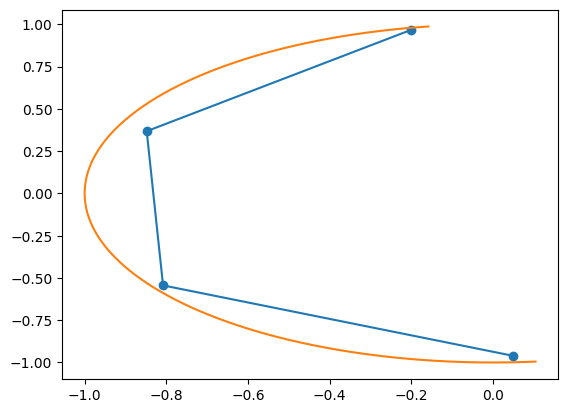

In [31]:

plt.plot([phase.real for phase in phase_estimates[:,1]], [phase.imag for phase in phase_estimates[:,1]])
plt.scatter([phase.real for phase in phase_estimates[:,1]], [phase.imag for phase in phase_estimates[:,1]])

ts = np.linspace(0.4, 0.46, 100)
ph = [np.exp(-1j * t * eigenvalues_sort[0]) for t in ts]
plt.plot([p.real for p in ph], [p.imag for p in ph])

#ts = np.linspace(0.22*0, 0.27*4, 100)
#ph1 = [np.exp(-1j * t * es) for t in ts]
#plt.plot([p.real for p in ph1], [p.imag for p in ph1])